<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_ID    500 non-null    object 
 1   Product_Name  500 non-null    object 
 2   Category      500 non-null    object 
 3   Price         500 non-null    float64
 4   Units_Sold    500 non-null    int64  
 5   Revenue       500 non-null    float64
 6   Rating        500 non-null    float64
 7   Return_Rate   500 non-null    float64
 8   Seller_Name   500 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 35.3+ KB
None
  Product_ID     Product_Name        Category   Price  Units_Sold    Revenue  \
0  Product_1    Max Product_1            Toys  358.65         983  352552.95   
1  Product_2    Pro Product_2  Home & Kitchen  248.00          79   19592.00   
2  Product_3    Eco Product_3      Automotive  148.12         206   30512.72   
3  Product_4  Super Product_4     E

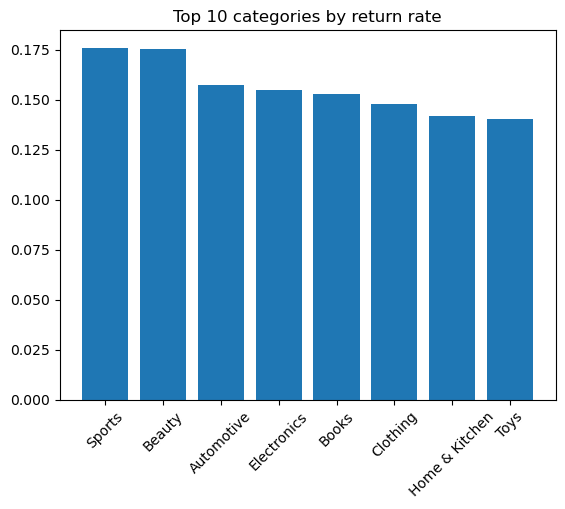

AUC: 0.5092838196286473


In [9]:
# data cleaning $ schema check
import pandas as pd

# Load dataset
df = pd.read_csv("C:/Users/selsha/Ecommerce_Product_Sales.csv")

# Standardize column names
df.columns = [c.strip() for c in df.columns]

# Inspect schema
print(df.info())
print(df.head())

# Convert Return_Rate → numeric
if df['Return_Rate'].dtype == object:
    df['Return_Rate_num'] = df['Return_Rate'].str.replace('%','', regex=False).astype(float) / 100.0
else:
    df['Return_Rate_num'] = pd.to_numeric(df['Return_Rate'], errors='coerce')

# Handle missing values
df = df.dropna(subset=['Return_Rate_num'])

# EDA
mean_rr = df['Return_Rate_num'].mean()
weighted_rr = (df['Return_Rate_num']*df['Units_Sold']).sum() / df['Units_Sold'].sum()
print("Simple mean:", mean_rr, "Weighted:", weighted_rr)

# Retrun % by category

by_cat = df.groupby('Category').agg(
    avg_return_rate=('Return_Rate_num','mean'),
    total_products=('Product_ID','count')).reset_index().sort_values('avg_return_rate', ascending=False)

# Return % by seller
by_seller = df.groupby('Seller_Name').agg(
    avg_return_rate=('Return_Rate_num','mean'),
    total_products=('Product_ID','count')).reset_index().sort_values('avg_return_rate', ascending=False)

# Top products
top_products = df.sort_values('Return_Rate_num', ascending=False).head(20)

# Visualization
import matplotlib.pyplot as plt
top10 = by_cat.head(10)
plt.bar(top10['Category'], top10['avg_return_rate'])
plt.xticks(rotation=45)
plt.title("Top 10 categories by return rate")
plt.show()

# Logistic Regression model + high-risk
cutoff = df['Return_Rate_num'].quantile(0.90)
df['high_return_obs'] = (df['Return_Rate_num'] >= cutoff).astype(int)

#Train classifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

features = ['Price','Units_Sold','Revenue','Rating','Category','Seller_Name']
X = df[features].fillna(0)
y = df['high_return_obs']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

num_features = ['Price','Units_Sold','Revenue','Rating']
cat_features = ['Category','Seller_Name']

preproc = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

pipe = Pipeline([
    ('prep', preproc),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipe.fit(X_train, y_train)
print("AUC:", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))

# predict & export high-risk products
df['pred_prob'] = pipe.predict_proba(X)[:,1]
pred_cutoff = df['pred_prob'].quantile(0.90)
df['high_return_pred'] = (df['pred_prob'] >= pred_cutoff).astype(int)

high_risk = df[df['high_return_pred']==1]
high_risk[['Product_ID','Product_Name','Category','Seller_Name','Units_Sold','Price','Return_Rate_num','pred_prob']].to_csv("high_risk_products.csv", index=False)

